In [93]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as scipy_stats

from plot_utilities import (
    setup_notebook_display,
    plot_coefficient_heatmap,
    sort_player_types,
)

setup_notebook_display(figsize=(10, 6))

df = pd.read_csv('../performance/player_strength_panel.csv')

# Derive dominant strategy from the model's own strategy ratios
strategy_cols = ['domination_ratio', 'culture_ratio', 'diplomatic_ratio', 'science_ratio']
strategy_labels = {c: c.replace('_ratio', '').title() for c in strategy_cols}
df['dominant_strategy'] = df[strategy_cols].idxmax(axis=1).map(strategy_labels)

print(f'Loaded {len(df)} rows, {df["player_type"].nunique()} player types, {df["game_id"].nunique()} games')
print(f'Dominant strategies: {sorted(df["dominant_strategy"].dropna().unique())}')
df[['player_type', 'dominant_strategy'] + strategy_cols + ['adjusted_strength']].head(10)

Loaded 2856 rows, 16 player types, 357 games
Dominant strategies: ['Culture', 'Diplomatic', 'Domination', 'Science']


player_type dominant_strategy  domination_ratio  culture_ratio  diplomatic_ratio  science_ratio  \
0               Vanilla           Science            0.2605         0.1403            0.0401         0.5591   
1               Vanilla           Science            0.4600         0.0000            0.0000         0.5400   
2               Vanilla           Science            0.0000         0.1600            0.0000         0.8400   
3               Vanilla        Domination            0.5600         0.0000            0.0000         0.4400   
4   GPT-OSS-120B-Simple           Science            0.0000         0.0020            0.0000         0.9980   
5  GPT-OSS-120B-Briefed        Diplomatic            0.2560         0.0120            0.7220         0.0100   
6        GLM-4.7-Simple           Science            0.0000         0.0029            0.0117         0.9854   
7       GLM-4.7-Briefed           Culture            0.0000         0.8520            0.0000         0.1480   
8               Vanilla        Diplomatic            0.0000         0.1617            0.5774         0.2610   
9               Vanilla        Domination            0.7373         0.0691            0.0000         0.1935   

   adjusted_strength  
0           0.149904  
1           0.076611  
2           0.108778  
3           0.697944  
4           0.794199  
5           0.999997  
6           0.010540  
7           0.006416  
8           0.999946  
9           0.594593

## Strategy Time Allocation

Mean strategy ratio by player type — how much of their game time each LLM dedicates to each victory path.

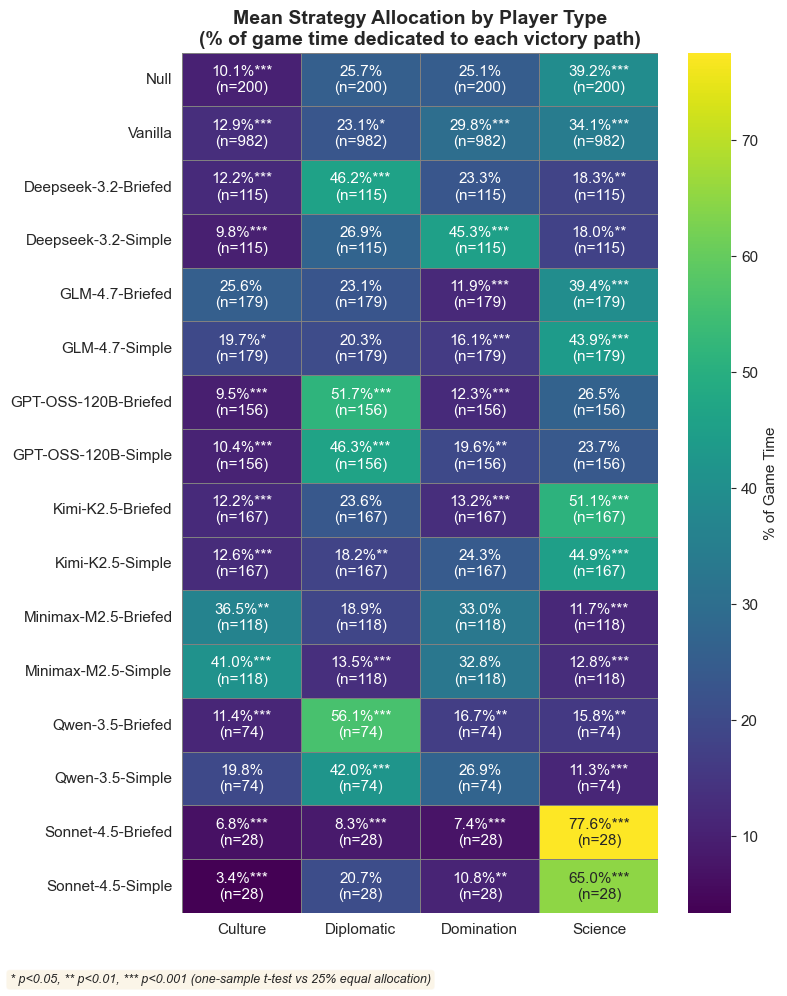

In [94]:
analysis_df = df[['player_type'] + strategy_cols].dropna()
player_types = sorted(analysis_df['player_type'].unique())
strategies = sorted(strategy_labels.values())

# Mean ratio per (player_type, strategy) — as percentage
ratio_means = analysis_df.groupby('player_type')[strategy_cols].mean() * 100
ratio_means.columns = [strategy_labels[c] for c in ratio_means.columns]
ratio_means = ratio_means.loc[player_types, strategies]

# Count per player type
count_df = pd.DataFrame(
    {s: analysis_df.groupby('player_type').size() for s in strategies},
    index=player_types
)

# Per-cell significance: one-sample t-test against 0.25 (equal allocation)
label_to_col = {v: k for k, v in strategy_labels.items()}
pval_data = []
for pt in player_types:
    pt_df = analysis_df[analysis_df['player_type'] == pt]
    pval_row = {}
    for s in strategies:
        values = pt_df[label_to_col[s]]
        if len(values) >= 2:
            _, p = scipy_stats.ttest_1samp(values, 0.25)
            pval_row[s] = p
        else:
            pval_row[s] = np.nan
    pval_data.append(pval_row)
pval_df = pd.DataFrame(pval_data, index=player_types)

fig, ax = plot_coefficient_heatmap(
    ratio_means, pval_df=pval_df, count_df=count_df,
    title='Mean Strategy Allocation by Player Type\n(% of game time dedicated to each victory path)',
    cbar_label='% of Game Time',
    cmap='viridis',
    value_fmt='{:.1f}%',
    footnote='* p<0.05, ** p<0.01, *** p<0.001 (one-sample t-test vs 25% equal allocation)'
)
plt.show()

## Dominant Strategy Frequency

Percentage of games where each strategy is the model's dominant target (highest ratio). Shown as deviation from Vanilla baseline.

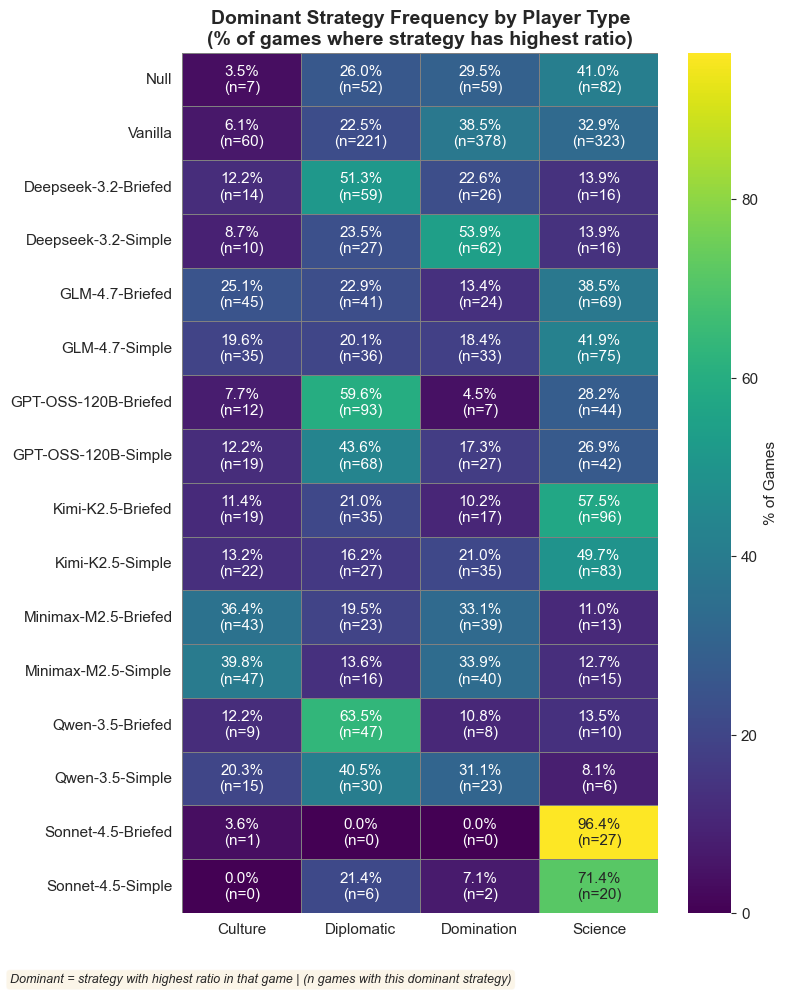

In [95]:
dom_df = df[['player_type', 'dominant_strategy']].dropna()

freq_data, count_data = [], []
for pt in player_types:
    pt_df = dom_df[dom_df['player_type'] == pt]
    n_total = len(pt_df)
    freq_row, count_row = {}, {}
    for s in strategies:
        n_s = (pt_df['dominant_strategy'] == s).sum()
        freq_row[s] = (n_s / n_total * 100) if n_total > 0 else 0
        count_row[s] = n_s
    freq_data.append(freq_row)
    count_data.append(count_row)

freq_df = pd.DataFrame(freq_data, index=player_types)
count_df = pd.DataFrame(count_data, index=player_types)

fig, ax = plot_coefficient_heatmap(
    freq_df, count_df=count_df,
    title='Dominant Strategy Frequency by Player Type\n(% of games where strategy has highest ratio)',
    cbar_label='% of Games',
    cmap='viridis',
    value_fmt='{:.1f}%',
    footnote='Dominant = strategy with highest ratio in that game | (n games with this dominant strategy)'
)
plt.show()

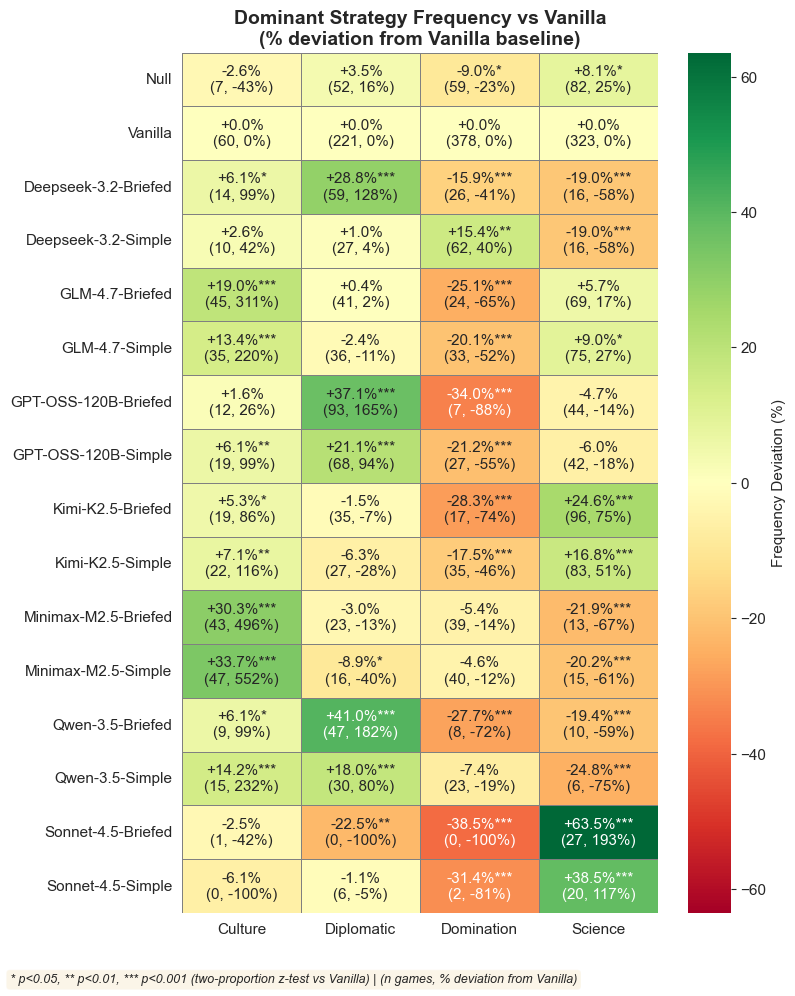

In [96]:
dom_df = df[['player_type', 'dominant_strategy']].dropna()

# Vanilla baseline frequencies
vanilla_dom = dom_df[dom_df['player_type'] == 'Vanilla']
n_vanilla = len(vanilla_dom)
vanilla_freqs = {}
for s in strategies:
    vanilla_freqs[s] = (vanilla_dom['dominant_strategy'] == s).sum() / n_vanilla * 100

freq_data, pval_data, count_data, pct_data = [], [], [], []
for pt in player_types:
    pt_df = dom_df[dom_df['player_type'] == pt]
    n_pt = len(pt_df)
    freq_row, pval_row, count_row, pct_row = {}, {}, {}, {}
    for s in strategies:
        n_s = (pt_df['dominant_strategy'] == s).sum()
        pt_freq = (n_s / n_pt * 100) if n_pt > 0 else 0
        vanilla_freq = vanilla_freqs[s]
        freq_row[s] = pt_freq - vanilla_freq

        # Two-proportion z-test
        n_vanilla_s = (vanilla_dom['dominant_strategy'] == s).sum()
        if n_pt > 0 and n_vanilla > 0:
            p_pool = (n_s + n_vanilla_s) / (n_pt + n_vanilla)
            se = np.sqrt(p_pool * (1 - p_pool) * (1/n_pt + 1/n_vanilla)) if p_pool > 0 and p_pool < 1 else np.nan
            if se and se > 0:
                z = (n_s/n_pt - n_vanilla_s/n_vanilla) / se
                pval_row[s] = 2 * (1 - scipy_stats.norm.cdf(abs(z)))
            else:
                pval_row[s] = np.nan
        else:
            pval_row[s] = np.nan

        count_row[s] = n_s
        pct_row[s] = ((pt_freq - vanilla_freq) / vanilla_freq * 100) if vanilla_freq != 0 else np.nan
    freq_data.append(freq_row)
    pval_data.append(pval_row)
    count_data.append(count_row)
    pct_data.append(pct_row)

freq_df = pd.DataFrame(freq_data, index=player_types)
pval_df = pd.DataFrame(pval_data, index=player_types)
count_df = pd.DataFrame(count_data, index=player_types)
pct_df = pd.DataFrame(pct_data, index=player_types)

max_abs = max(abs(freq_df.min().min()), abs(freq_df.max().max()), 0.01)

fig, ax = plot_coefficient_heatmap(
    freq_df, pval_df=pval_df, count_df=count_df, pct_df=pct_df,
    title='Dominant Strategy Frequency vs Vanilla\n(% deviation from Vanilla baseline)',
    cbar_label='Frequency Deviation (%)',
    vmin=-max_abs, vmax=max_abs, center=0, cmap='RdYlGn',
    value_fmt='{:+.1f}%',
    footnote='* p<0.05, ** p<0.01, *** p<0.001 (two-proportion z-test vs Vanilla) | (n games, % deviation from Vanilla)'
)
plt.show()

## Strategic Commitment

When a model targets a given strategy as dominant, how much of its time goes to that strategy? Shown as deviation from Vanilla's commitment level. Positive = more focused than Vanilla.

c:\Users\John Chen\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


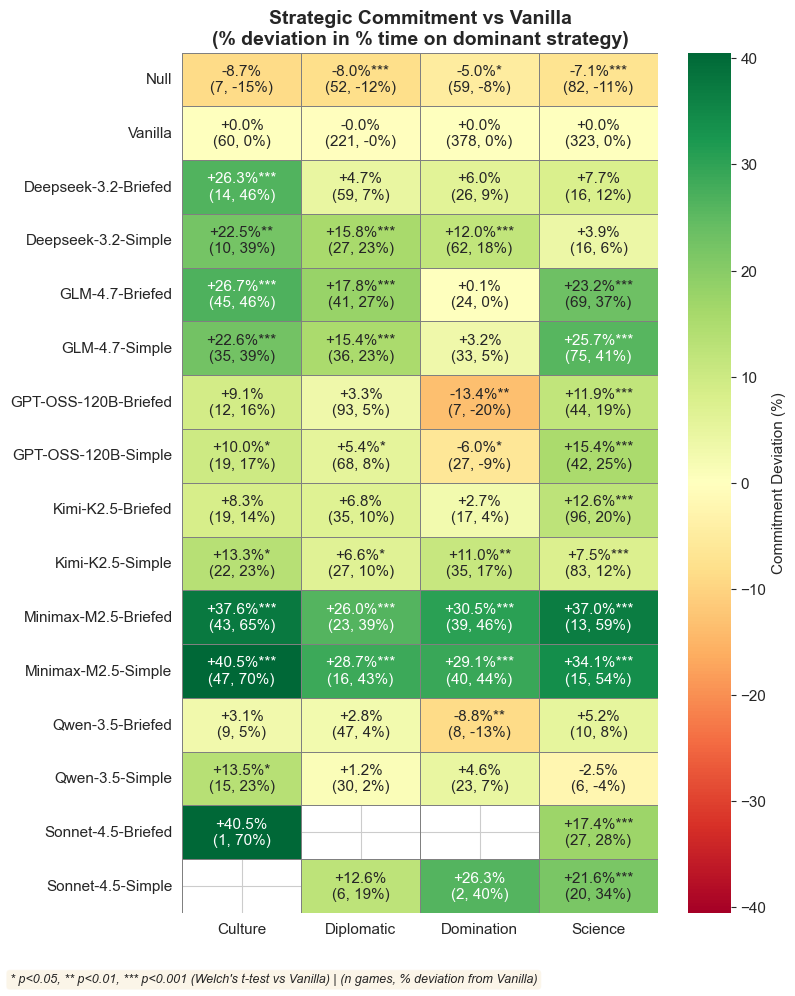

In [97]:
commit_df_full = df[['player_type', 'dominant_strategy'] + strategy_cols].dropna()
label_to_col = {v: k for k, v in strategy_labels.items()}

# Vanilla baseline commitment values (per strategy)
vanilla_commit = commit_df_full[commit_df_full['player_type'] == 'Vanilla']
vanilla_commit_means = {}
vanilla_commit_values = {}
for s in strategies:
    mask = vanilla_commit['dominant_strategy'] == s
    vals = vanilla_commit.loc[mask, label_to_col[s]]
    vanilla_commit_means[s] = vals.mean() * 100 if len(vals) > 0 else np.nan
    vanilla_commit_values[s] = vals * 100  # keep raw values for t-test

dev_data, pval_data, count_data, pct_data = [], [], [], []
for pt in player_types:
    pt_df = commit_df_full[commit_df_full['player_type'] == pt]
    dev_row, pval_row, count_row, pct_row = {}, {}, {}, {}
    for s in strategies:
        mask = pt_df['dominant_strategy'] == s
        subset = pt_df.loc[mask, label_to_col[s]] * 100
        pt_mean = subset.mean() if len(subset) > 0 else np.nan
        van_mean = vanilla_commit_means[s]

        dev_row[s] = (pt_mean - van_mean) if not np.isnan(pt_mean) and not np.isnan(van_mean) else np.nan

        # Welch's t-test vs Vanilla
        van_vals = vanilla_commit_values[s]
        if len(subset) >= 2 and len(van_vals) >= 2:
            _, p = scipy_stats.ttest_ind(subset, van_vals, equal_var=False)
            pval_row[s] = p
        else:
            pval_row[s] = np.nan

        count_row[s] = len(subset)
        pct_row[s] = ((pt_mean - van_mean) / van_mean * 100) if (not np.isnan(pt_mean) and not np.isnan(van_mean) and van_mean != 0) else np.nan

    dev_data.append(dev_row)
    pval_data.append(pval_row)
    count_data.append(count_row)
    pct_data.append(pct_row)

dev_df = pd.DataFrame(dev_data, index=player_types)
pval_df = pd.DataFrame(pval_data, index=player_types)
count_df = pd.DataFrame(count_data, index=player_types)
pct_df = pd.DataFrame(pct_data, index=player_types)

max_abs = max(abs(dev_df.min().min()), abs(dev_df.max().max()), 0.01)

fig, ax = plot_coefficient_heatmap(
    dev_df, pval_df=pval_df, count_df=count_df, pct_df=pct_df,
    title='Strategic Commitment vs Vanilla\n(% deviation in % time on dominant strategy)',
    cbar_label='Commitment Deviation (%)',
    vmin=-max_abs, vmax=max_abs, center=0, cmap='RdYlGn',
    value_fmt='{:+.1f}%',
    footnote='* p<0.05, ** p<0.01, *** p<0.001 (Welch\'s t-test vs Vanilla) | (n games, % deviation from Vanilla)'
)
plt.show()

## Strategy Adaptation

Turn-level analysis of when and why models pivot their grand strategy during a game. Uses forward-filled `grand_strategy` from turn_data, joined with MLP-predicted win probability.

In [98]:
from plot_utilities import (
    load_turn_data, forward_fill_strategy,
    compute_post_pivot_win_prob, detect_strategy_pivots,
    plot_violin, bootstrap_ci, plot_forest_plot,
    sort_player_types, get_player_color, get_player_marker,
)
import seaborn as sns

# Load turn data and predictions
turn_df = load_turn_data(csv_path='../turn_data.csv', print_metadata=False)
pred_turn = pd.read_csv('../models/output/attention_mlp_predictions.csv')

# Forward-fill grand_strategy and map to display names
forward_fill_strategy(turn_df)

# Compute turn_progress
turn_df['turn_progress'] = turn_df['turn'] / turn_df['max_turn']

# Join with predictions for win probability
turn_df = turn_df.merge(
    pred_turn[['game_id', 'player_id', 'turn', 'predicted_win_probability']],
    on=['game_id', 'player_id', 'turn'], how='left'
)

# Detect pivots: turns where strategy differs from previous turn (>= turn 30 to exclude initial setups)
pivots = detect_strategy_pivots(turn_df, min_turn=25)
player_order = sort_player_types(turn_df['player_type'].unique())

print(f'Total pivots: {len(pivots)}')
print(f'Pivots per player type:')
print(pivots.groupby('player_type').size().sort_index())
print(f'\nPivot coverage: {pivots["predicted_win_probability"].notna().mean():.1%} have win prob')

d:\Cache\Onedrive - Arizona\OneDrive - University of Arizona\Vox Deorum\nlp-2026-tiny-4player\analysis\behaviors\..\plot_utilities.py:881: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Total pivots: 16855
Pivots per player type:
player_type
Deepseek-3.2-Briefed      248
Deepseek-3.2-Simple       253
GLM-4.7-Briefed           470
GLM-4.7-Simple            458
GPT-OSS-120B-Briefed      506
GPT-OSS-120B-Simple       447
Kimi-K2.5-Briefed         968
Kimi-K2.5-Simple          824
Minimax-M2.5-Briefed       17
Minimax-M2.5-Simple        11
Null                      916
Qwen-3.5-Briefed          365
Qwen-3.5-Simple           196
Sonnet-4.5-Briefed        287
Sonnet-4.5-Simple          78
Vanilla                 10811
dtype: int64

Pivot coverage: 99.8% have win prob


### Pivot Timing Distribution

When in the game do models switch strategies? Violin plot showing the turn_progress distribution of all strategy pivots.

d:\Cache\Onedrive - Arizona\OneDrive - University of Arizona\Vox Deorum\nlp-2026-tiny-4player\analysis\behaviors\..\plot_utilities.py:3506: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


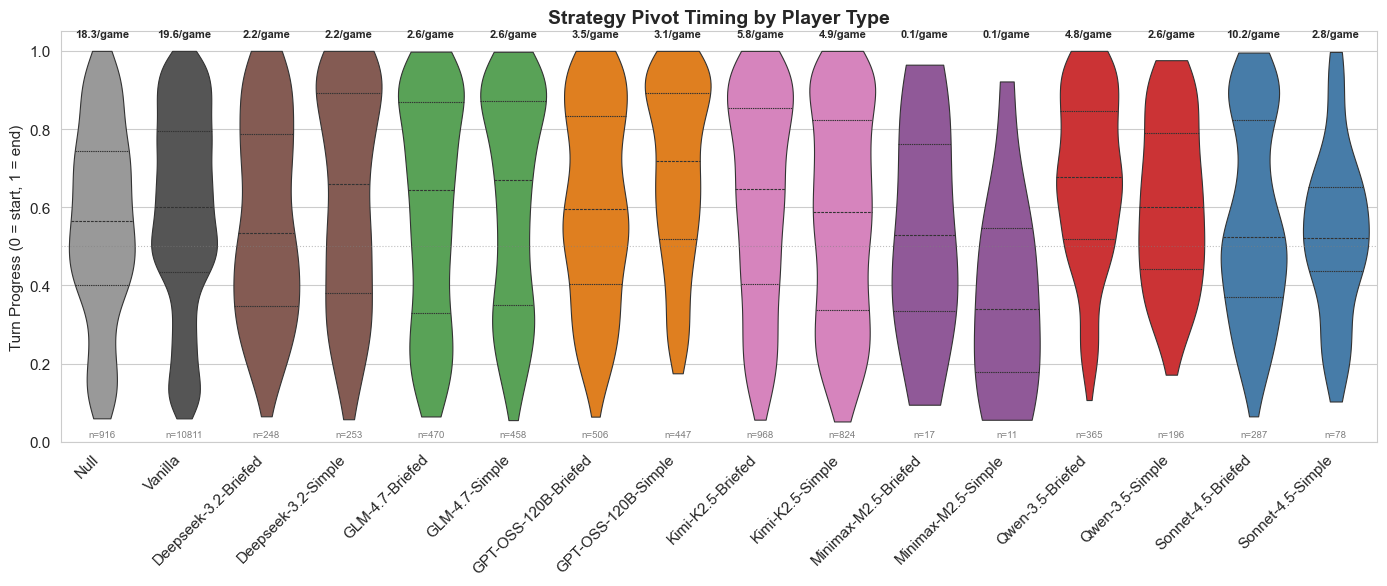

(<Figure size 1400x600 with 1 Axes>,
 [<Axes: title={'center': 'Strategy Pivot Timing by Player Type'}, ylabel='Turn Progress (0 = start, 1 = end)'>])

In [99]:
# Avg pivots per game for annotation
pivot_counts = pivots.groupby('player_type').size()
games_per_pt = turn_df.groupby('player_type')['game_id'].nunique()
avg_pivots = (pivot_counts / games_per_pt).to_dict()

plot_violin(
    pivots, y='turn_progress',
    title='Strategy Pivot Timing by Player Type',
    ylabel='Turn Progress (0 = start, 1 = end)',
    hline=0.5,
    annotations=avg_pivots, annotation_fmt='{:.1f}/game', annotation_pos='above',
    figsize=(14, 6), ylim=(0, 1.05),
)

### Pivot Timing by Victory Probability

At what win probability do models pivot their strategy? Box plots of predicted victory probability at pivot time, with player types on the x-axis and pivot rates annotated per game.

Pivots with win prob: 16821
                    n    median      mean
strategy_filled                          
Culture          2625  0.063176  0.160136
Diplomatic       4413  0.081244  0.166643
Domination       3029  0.016876  0.084208
Science          6754  0.026344  0.107833


C:\Users\John Chen\AppData\Local\Temp\ipykernel_21436\1979452474.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


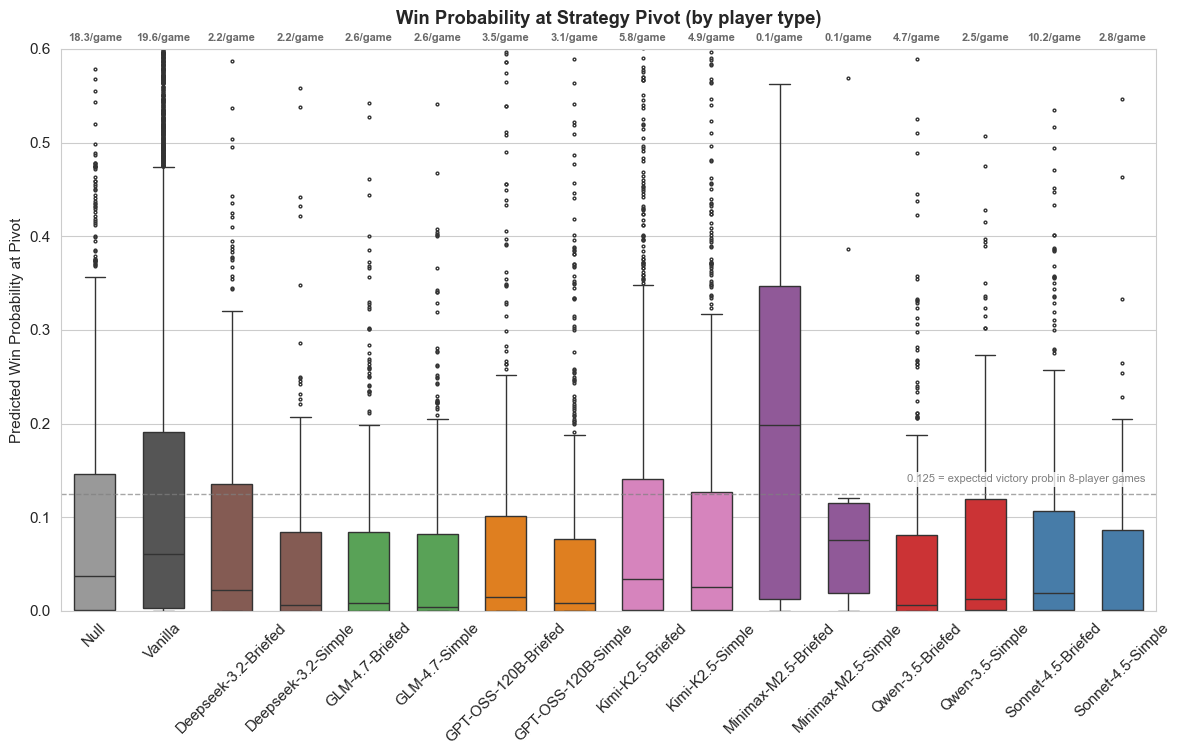

In [100]:
pivot_wp = pivots.dropna(subset=['predicted_win_probability', 'strategy_filled']).copy()

print(f'Pivots with win prob: {len(pivot_wp)}')
print(pivot_wp.groupby('strategy_filled').agg(
    n=('predicted_win_probability', 'size'),
    median=('predicted_win_probability', 'median'),
    mean=('predicted_win_probability', 'mean'),
).to_string())

pivot_wp_plot = pivot_wp[pivot_wp['predicted_win_probability'] > 0].copy()
dropped_nonpositive = len(pivot_wp) - len(pivot_wp_plot)
if dropped_nonpositive:
    print(f'Excluded {dropped_nonpositive} non-positive win probs for log-scale plotting')

games_per_pt = turn_df.groupby('player_type')['game_id'].nunique()
pivot_counts = pivot_wp_plot.groupby('player_type').size()
pivots_per_game = (pivot_counts / games_per_pt).reindex(player_order).fillna(0.0)
positive_min = pivot_wp_plot['predicted_win_probability'].min()
y_min = 10 ** np.floor(np.log10(positive_min))

palette = [get_player_color(pt) for pt in player_order]

fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(
    data=pivot_wp_plot,
    x='player_type',
    y='predicted_win_probability',
    order=player_order,
    palette=palette,
    width=0.6,
    fliersize=2,
    ax=ax,
)

ax.set_title('Win Probability at Strategy Pivot (by player type)', fontweight='bold', pad=18)
ax.set_xlabel('')
ax.set_ylabel('Predicted Win Probability at Pivot')
ax.set_ylim(y_min, 0.6)
ax.tick_params(axis='x', rotation=45)
ax.axhline(0.125, color='gray', linestyle='--', linewidth=1, alpha=0.7)
ax.text(
    0.99,
    0.125 * 1.08,
    '0.125 = expected victory prob in 8-player games',
    transform=ax.get_yaxis_transform(),
    ha='right',
    va='bottom',
    fontsize=8,
    color='gray',
    bbox={'facecolor': 'white', 'edgecolor': 'none', 'alpha': 0.8, 'pad': 1.5},
)

for i, pt in enumerate(player_order):
    ax.text(
        i,
        1.01,
        f'{pivots_per_game.loc[pt]:.1f}/game',
        transform=ax.get_xaxis_transform(),
        ha='center',
        va='bottom',
        fontsize=8,
        fontweight='bold',
        color='dimgray',
        clip_on=False,
    )

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Pivot Flow by Player Type

When models pivot, what do they switch between? Faceted heatmaps showing (from → to) transition rates per game with average predicted win probability at pivot time annotated in each cell.

In [101]:
from matplotlib.colors import LogNorm

strat_order = sorted(pivots['strategy_filled'].dropna().unique())

# Number of games per player type (for normalization)
games_per_pt = turn_df.groupby('player_type')['game_id'].nunique()

n_cols = 4
n_rows = int(np.ceil(len(player_order) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3.5 * n_rows))
axes_flat = axes.flatten()

# Shared color scale: find global min/max rate (per game)
global_max = 0
global_min = np.inf
for pt in player_order:
    pt_pivots = pivots[pivots['player_type'] == pt]
    n_games = games_per_pt.get(pt, 1)
    counts = pt_pivots.groupby(['prev_strategy', 'strategy_filled']).size() / n_games
    if len(counts) > 0:
        global_max = max(global_max, counts.max())
        positive = counts[counts > 0]
        if len(positive) > 0:
            global_min = min(global_min, positive.min())

if global_min == np.inf:
    global_min = 0.01
log_norm = LogNorm(vmin=max(global_min, 1e-3), vmax=max(global_max, 0.01))

for idx, pt in enumerate(player_order):
    ax = axes_flat[idx]
    pt_pivots = pivots[pivots['player_type'] == pt]
    n_games = games_per_pt.get(pt, 1)

    # Build rate and avg win prob matrices
    rate_matrix = pd.DataFrame(0.0, index=strat_order, columns=strat_order)
    prob_matrix = pd.DataFrame(np.nan, index=strat_order, columns=strat_order)

    for (from_s, to_s), grp in pt_pivots.groupby(['prev_strategy', 'strategy_filled']):
        if from_s in strat_order and to_s in strat_order:
            rate_matrix.loc[from_s, to_s] = len(grp) / n_games
            prob_matrix.loc[from_s, to_s] = grp['predicted_win_probability'].mean()

    # Replace 0 with NaN so log scale skips empty cells
    rate_for_plot = rate_matrix.replace(0, np.nan)

    # Build annotation: "rate\n(p=0.XX)"
    annot = np.empty(rate_matrix.shape, dtype=object)
    for i in range(len(strat_order)):
        for j in range(len(strat_order)):
            r = rate_matrix.iloc[i, j]
            p = prob_matrix.iloc[i, j]
            if r > 0 and not np.isnan(p):
                annot[i, j] = f'{r:.2f}\n(p={p:.2f})'
            elif r > 0:
                annot[i, j] = f'{r:.2f}'
            else:
                annot[i, j] = ''

    sns.heatmap(
        rate_for_plot, annot=annot, fmt='', cmap='viridis',
        norm=log_norm,
        linewidths=0.5, linecolor='gray', ax=ax,
        cbar=False, square=True
    )
    ax.set_title(pt, fontsize=9, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    if idx % n_cols == 0:
        ax.set_ylabel('From', fontsize=9)
    if idx >= (n_rows - 1) * n_cols:
        ax.set_xlabel('To', fontsize=9)
    ax.tick_params(labelsize=7)

# Remove empty subplots
for idx in range(len(player_order), len(axes_flat)):
    axes_flat[idx].set_visible(False)

fig.suptitle('Strategy Pivot Flow by Player Type\n(pivots per game, avg predicted win prob at pivot)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Strategy Choice vs Pivoting vs Execution

For each player type, compare the strategy it chooses most often, the strategy it pivots into most often, and its highest-ELO strategy.

                     most_chosen_strategy  most_chosen_share  most_chosen_count most_pivoted_to_strategy  most_pivoted_to_share  most_pivoted_to_count best_elo_strategy  best_elo
Null                              Science               41.0                 82                  Science                   47.2                    432           Science    1341.8
Vanilla                        Domination               38.5                378                  Science                   44.9                   4858           Culture    1583.9
Deepseek-3.2-Briefed           Diplomatic               51.3                 59               Diplomatic                   53.2                    132           Science    1458.0
Deepseek-3.2-Simple            Domination               53.9                 62               Domination                   42.3                    107           Science    1386.7
GLM-4.7-Briefed                   Science               38.5                 69                  Science 

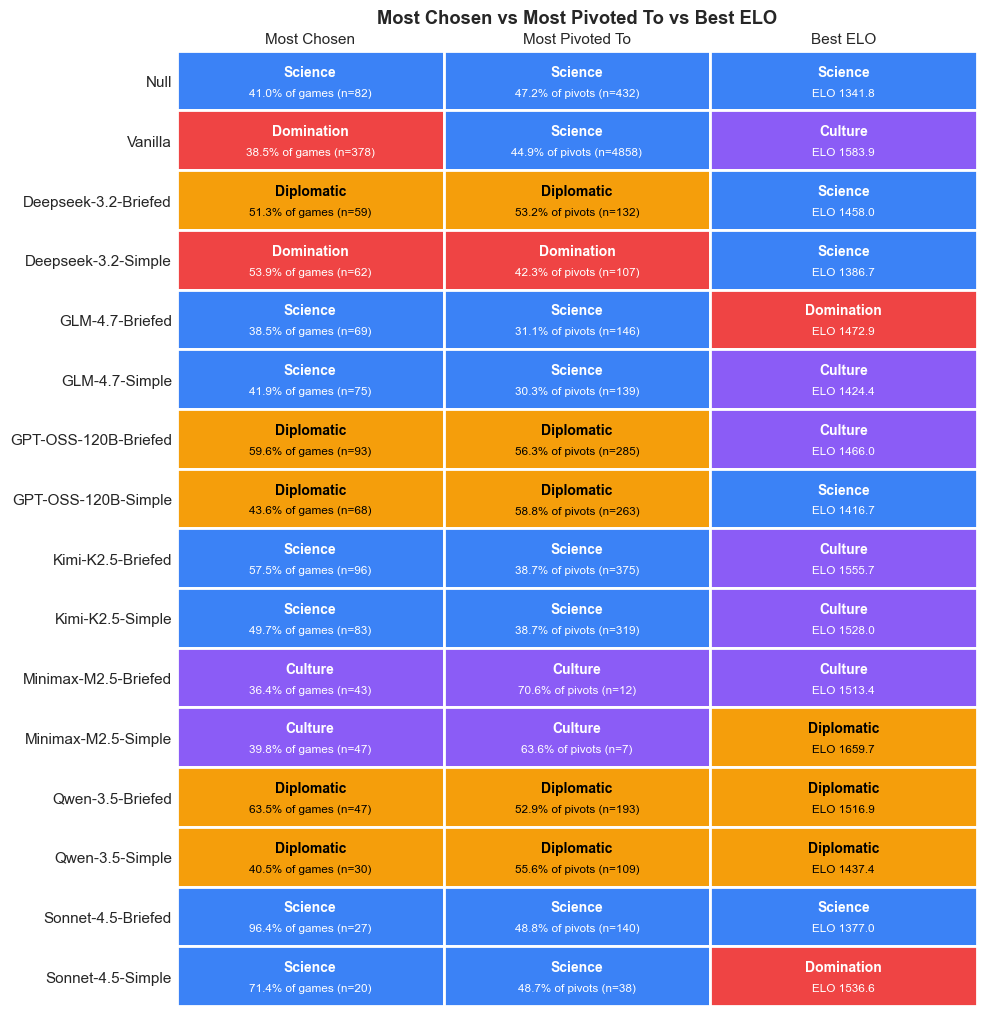

In [102]:
# Summarize dominant choice, pivot destination, and best-executed strategy
summary_player_types = player_order

tile_strategy_colors = {
    'Culture': '#8B5CF6',
    'Diplomatic': '#F59E0B',
    'Domination': '#EF4444',
    'Science': '#3B82F6',
    'Time': '#9CA3AF',
    'No games': '#E5E7EB',
    'No pivots': '#E5E7EB',
    'No rating': '#E5E7EB',
}

dominant_counts = (
    pd.crosstab(df['player_type'], df['dominant_strategy'])
    .reindex(summary_player_types)
    .fillna(0)
)

top_choice_rows = []
for pt in summary_player_types:
    pt_counts = dominant_counts.loc[pt]
    total = pt_counts.sum()
    if total <= 0:
        top_choice_rows.append(('No games', np.nan, 0))
        continue
    strategy = pt_counts.idxmax()
    n_games = int(pt_counts.max())
    share = n_games / total * 100
    top_choice_rows.append((strategy, share, n_games))

top_choice_df = pd.DataFrame(
    top_choice_rows,
    index=summary_player_types,
    columns=['most_chosen_strategy', 'most_chosen_share', 'most_chosen_count'],
)

pivot_destination_counts = (
    pd.crosstab(pivots['player_type'], pivots['strategy_filled'])
    .reindex(summary_player_types)
    .fillna(0)
)

top_pivot_rows = []
for pt in summary_player_types:
    pt_counts = pivot_destination_counts.loc[pt]
    total = pt_counts.sum()
    if total <= 0:
        top_pivot_rows.append(('No pivots', np.nan, 0))
        continue
    strategy = pt_counts.idxmax()
    n_pivots = int(pt_counts.max())
    share = n_pivots / total * 100
    top_pivot_rows.append((strategy, share, n_pivots))

top_pivot_df = pd.DataFrame(
    top_pivot_rows,
    index=summary_player_types,
    columns=['most_pivoted_to_strategy', 'most_pivoted_to_share', 'most_pivoted_to_count'],
)

strategy_elo_df = pd.read_csv('../ratings/output/strategy_elo_ratings.csv')
elo_by_player = (
    strategy_elo_df
    .pivot_table(index='player_type', columns='strategy', values='elo', aggfunc='first')
    .reindex(summary_player_types)
)

best_elo_rows = []
for pt in summary_player_types:
    pt_elo = elo_by_player.loc[pt].dropna()
    if len(pt_elo) == 0:
        best_elo_rows.append(('No rating', np.nan))
    else:
        best_elo_rows.append((pt_elo.idxmax(), pt_elo.max()))

best_elo_df = pd.DataFrame(
    best_elo_rows,
    index=summary_player_types,
    columns=['best_elo_strategy', 'best_elo'],
)

strategy_summary = top_choice_df.join(top_pivot_df).join(best_elo_df)

print(
    strategy_summary.round({
        'most_chosen_share': 1,
        'most_pivoted_to_share': 1,
        'best_elo': 1,
    }).to_string()
)

tile_columns = ['Most Chosen', 'Most Pivoted To', 'Best ELO']
fig, ax = plt.subplots(figsize=(10, len(summary_player_types) * 0.55 + 1.5))

for i, pt in enumerate(summary_player_types):
    row = strategy_summary.loc[pt]
    entries = [
        (
            row['most_chosen_strategy'],
            (
                f"{row['most_chosen_share']:.1f}% of games (n={int(row['most_chosen_count'])})"
                if row['most_chosen_count']
                else 'No games'
            ),
        ),
        (
            row['most_pivoted_to_strategy'],
            (
                f"{row['most_pivoted_to_share']:.1f}% of pivots (n={int(row['most_pivoted_to_count'])})"
                if row['most_pivoted_to_count']
                else 'No pivots'
            ),
        ),
        (
            row['best_elo_strategy'],
            f"ELO {row['best_elo']:.1f}" if pd.notna(row['best_elo']) else 'No rating',
        ),
    ]

    for j, (strategy, detail) in enumerate(entries):
        facecolor = tile_strategy_colors.get(strategy, '#E5E7EB')
        text_color = 'black' if strategy in ['Diplomatic', 'Time', 'No games', 'No pivots', 'No rating'] else 'white'
        rect = plt.Rectangle(
            (j, i),
            1,
            1,
            facecolor=facecolor,
            edgecolor='white',
            linewidth=2,
        )
        ax.add_patch(rect)
        ax.text(
            j + 0.5,
            i + 0.35,
            strategy,
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            color=text_color,
        )
        ax.text(
            j + 0.5,
            i + 0.70,
            detail,
            ha='center',
            va='center',
            fontsize=8.5,
            color=text_color,
        )

ax.set_xlim(0, len(tile_columns))
ax.set_ylim(0, len(summary_player_types))
ax.invert_yaxis()
ax.set_xticks(np.arange(len(tile_columns)) + 0.5)
ax.set_xticklabels(tile_columns)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(len(summary_player_types)) + 0.5)
ax.set_yticklabels(summary_player_types)
ax.tick_params(length=0)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title('Most Chosen vs Most Pivoted To vs Best ELO', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Pivot Flow Vector Similarity

For each LLM player type, the 4×4 transition rate matrix above is flattened into a 12-element vector (off-diagonal entries only, since self-transitions are structurally zero). Pairwise Pearson correlations between these vectors reveal which player types share similar pivot "fingerprints." We then compare **simple-briefed pairs** (same base model, different prompt) to **cross-model pairs**.

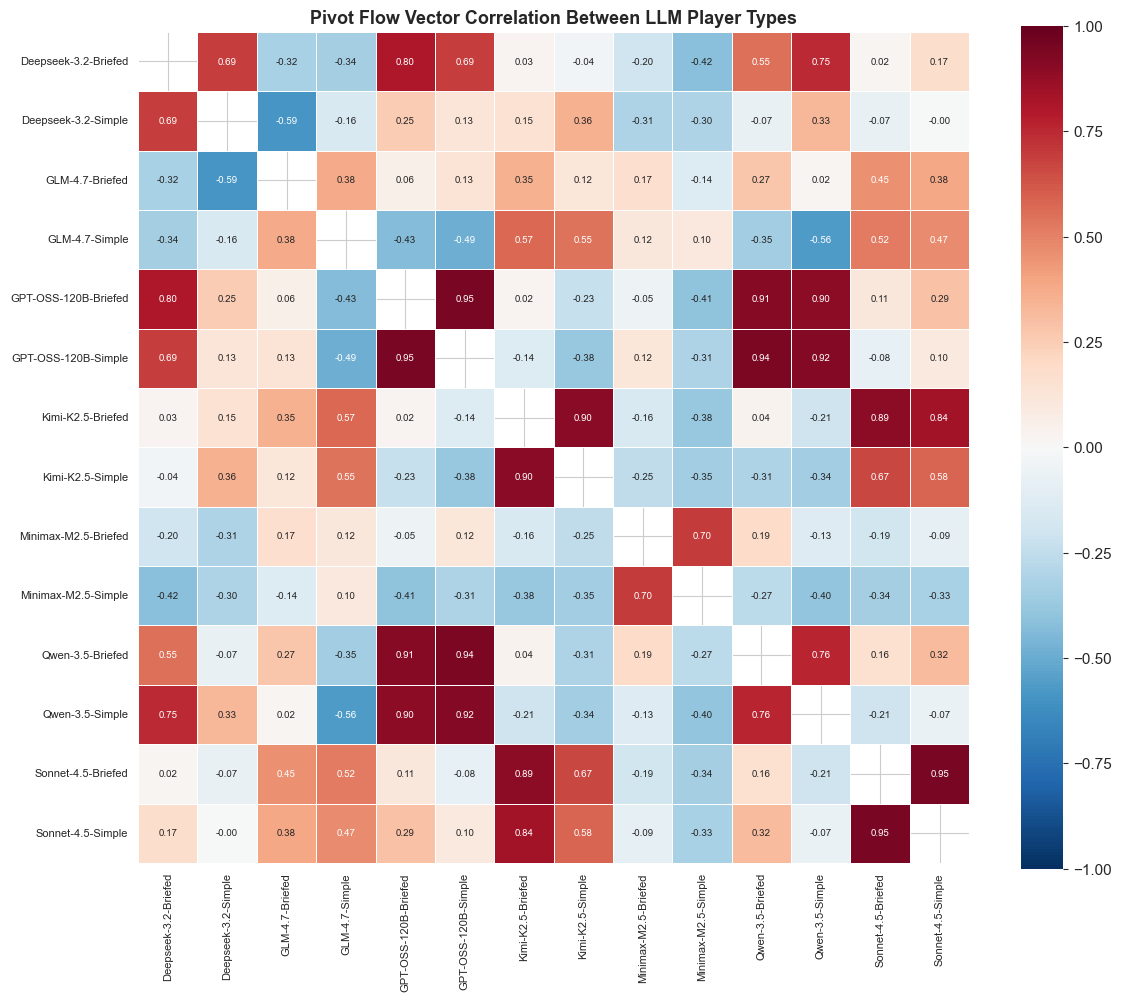

In [103]:
from itertools import combinations

# --- Build flow vectors for LLM player types ---
llm_types = [pt for pt in player_order if pt not in ('Null', 'Vanilla')]

# Off-diagonal (from, to) pairs
offdiag_pairs = [(s1, s2) for s1 in strat_order for s2 in strat_order if s1 != s2]
offdiag_labels = [f'{s1[:2]}\u2192{s2[:2]}' for s1, s2 in offdiag_pairs]

flow_vectors = {}
for pt in llm_types:
    pt_pivots = pivots[pivots['player_type'] == pt]
    n_games = games_per_pt.get(pt, 1)
    rm = pd.DataFrame(0.0, index=strat_order, columns=strat_order)
    for (from_s, to_s), grp in pt_pivots.groupby(['prev_strategy', 'strategy_filled']):
        if from_s in strat_order and to_s in strat_order:
            rm.loc[from_s, to_s] = len(grp) / n_games
    flow_vectors[pt] = [rm.loc[s1, s2] for s1, s2 in offdiag_pairs]

flow_df = pd.DataFrame(flow_vectors, index=offdiag_labels).T

# --- Exclude zero-variance vectors (no pivots at all) ---
nonzero_types = [pt for pt in llm_types if flow_df.loc[pt].sum() > 0]
if len(nonzero_types) < len(llm_types):
    dropped = set(llm_types) - set(nonzero_types)
    print(f'Warning: dropped {dropped} (zero pivots, correlation undefined)')

# --- Pairwise Pearson correlation ---
corr_matrix = flow_df.loc[nonzero_types].T.corr()

# --- Helper: extract base model name ---
def get_base_model(pt):
    for suffix in ('-Simple', '-Briefed'):
        if pt.endswith(suffix):
            return pt[:-len(suffix)]
    return pt

# --- Identify simple-briefed pairs ---
sb_pairs = set()
base_to_pts = {}
for pt in nonzero_types:
    base_to_pts.setdefault(get_base_model(pt), []).append(pt)
for base, pts in base_to_pts.items():
    simple = [p for p in pts if p.endswith('-Simple')]
    briefed = [p for p in pts if p.endswith('-Briefed')]
    for s in simple:
        for b in briefed:
            sb_pairs.add(frozenset([s, b]))

# --- Plot correlation heatmap ---
mask = np.eye(len(nonzero_types), dtype=bool)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr_matrix.loc[nonzero_types, nonzero_types],
    annot=True, fmt='.2f', annot_kws={'size': 7},
    cmap='RdBu_r', center=0, vmin=-1, vmax=1,
    mask=mask, linewidths=0.5, ax=ax, square=True,
)
ax.set_title('Pivot Flow Vector Correlation Between LLM Player Types',
             fontsize=13, fontweight='bold')
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

In [104]:
from scipy.stats import mannwhitneyu

# --- Compute pairwise MAD and collect correlations ---
pair_results = []
for pt_a, pt_b in combinations(nonzero_types, 2):
    vec_a = np.array(flow_vectors[pt_a])
    vec_b = np.array(flow_vectors[pt_b])
    mad = np.mean(np.abs(vec_a - vec_b))
    corr = corr_matrix.loc[pt_a, pt_b]
    is_sb = frozenset([pt_a, pt_b]) in sb_pairs
    pair_results.append({
        'pair': f'{pt_a}  vs  {pt_b}',
        'mad': mad,
        'correlation': corr,
        'is_simple_briefed': is_sb,
    })

pair_df = pd.DataFrame(pair_results)

# --- Split and summarize ---
sb = pair_df[pair_df['is_simple_briefed']]
other = pair_df[~pair_df['is_simple_briefed']]

print('=== Pairwise Flow Vector Differences ===\n')
print(f'Simple-Briefed pairs (n={len(sb)}):')
print(f'  Mean MAD:    {sb["mad"].mean():.4f}')
print(f'  Median MAD:  {sb["mad"].median():.4f}')
print(f'  Mean corr:   {sb["correlation"].mean():.3f}')
print()
print(f'Other pairs (n={len(other)}):')
print(f'  Mean MAD:    {other["mad"].mean():.4f}')
print(f'  Median MAD:  {other["mad"].median():.4f}')
print(f'  Mean corr:   {other["correlation"].mean():.3f}')

# --- Statistical test ---
if len(sb) >= 2 and len(other) >= 2:
    stat, p = mannwhitneyu(sb['mad'], other['mad'], alternative='two-sided')
    print(f'\nMann-Whitney U test (MAD): U={stat:.1f}, p={p:.4f}')

# --- Detail table for simple-briefed pairs ---
print('\n--- Simple-Briefed Pair Details ---')
for _, row in sb.sort_values('mad').iterrows():
    print(f"  {row['pair']:55s}  MAD={row['mad']:.4f}  r={row['correlation']:.3f}")

=== Pairwise Flow Vector Differences ===

Simple-Briefed pairs (n=7):
  Mean MAD:    0.1698
  Median MAD:  0.0981
  Mean corr:   0.764

Other pairs (n=84):
  Mean MAD:    0.3301
  Median MAD:  0.2557
  Mean corr:   0.073

Mann-Whitney U test (MAD): U=98.0, p=0.0022

--- Simple-Briefed Pair Details ---
  Minimax-M2.5-Briefed  vs  Minimax-M2.5-Simple            MAD=0.0099  r=0.703
  GLM-4.7-Briefed  vs  GLM-4.7-Simple                      MAD=0.0652  r=0.383
  GPT-OSS-120B-Briefed  vs  GPT-OSS-120B-Simple            MAD=0.0718  r=0.951
  Deepseek-3.2-Briefed  vs  Deepseek-3.2-Simple            MAD=0.0981  r=0.690
  Kimi-K2.5-Briefed  vs  Kimi-K2.5-Simple                  MAD=0.1088  r=0.904
  Qwen-3.5-Briefed  vs  Qwen-3.5-Simple                    MAD=0.2007  r=0.762
  Sonnet-4.5-Briefed  vs  Sonnet-4.5-Simple                MAD=0.6339  r=0.952


### Pivot Impact: Before vs After Win Probability

Did the strategy pivot help? Each dot is a pivot event. Y-axis shows predicted win probability at pivot time; X-axis shows the linear-decay weighted average win probability over the next N turns (closer turns weighted more). Points below the diagonal indicate the pivot improved the model's position.

Pivots with before+after data: 16791/16855


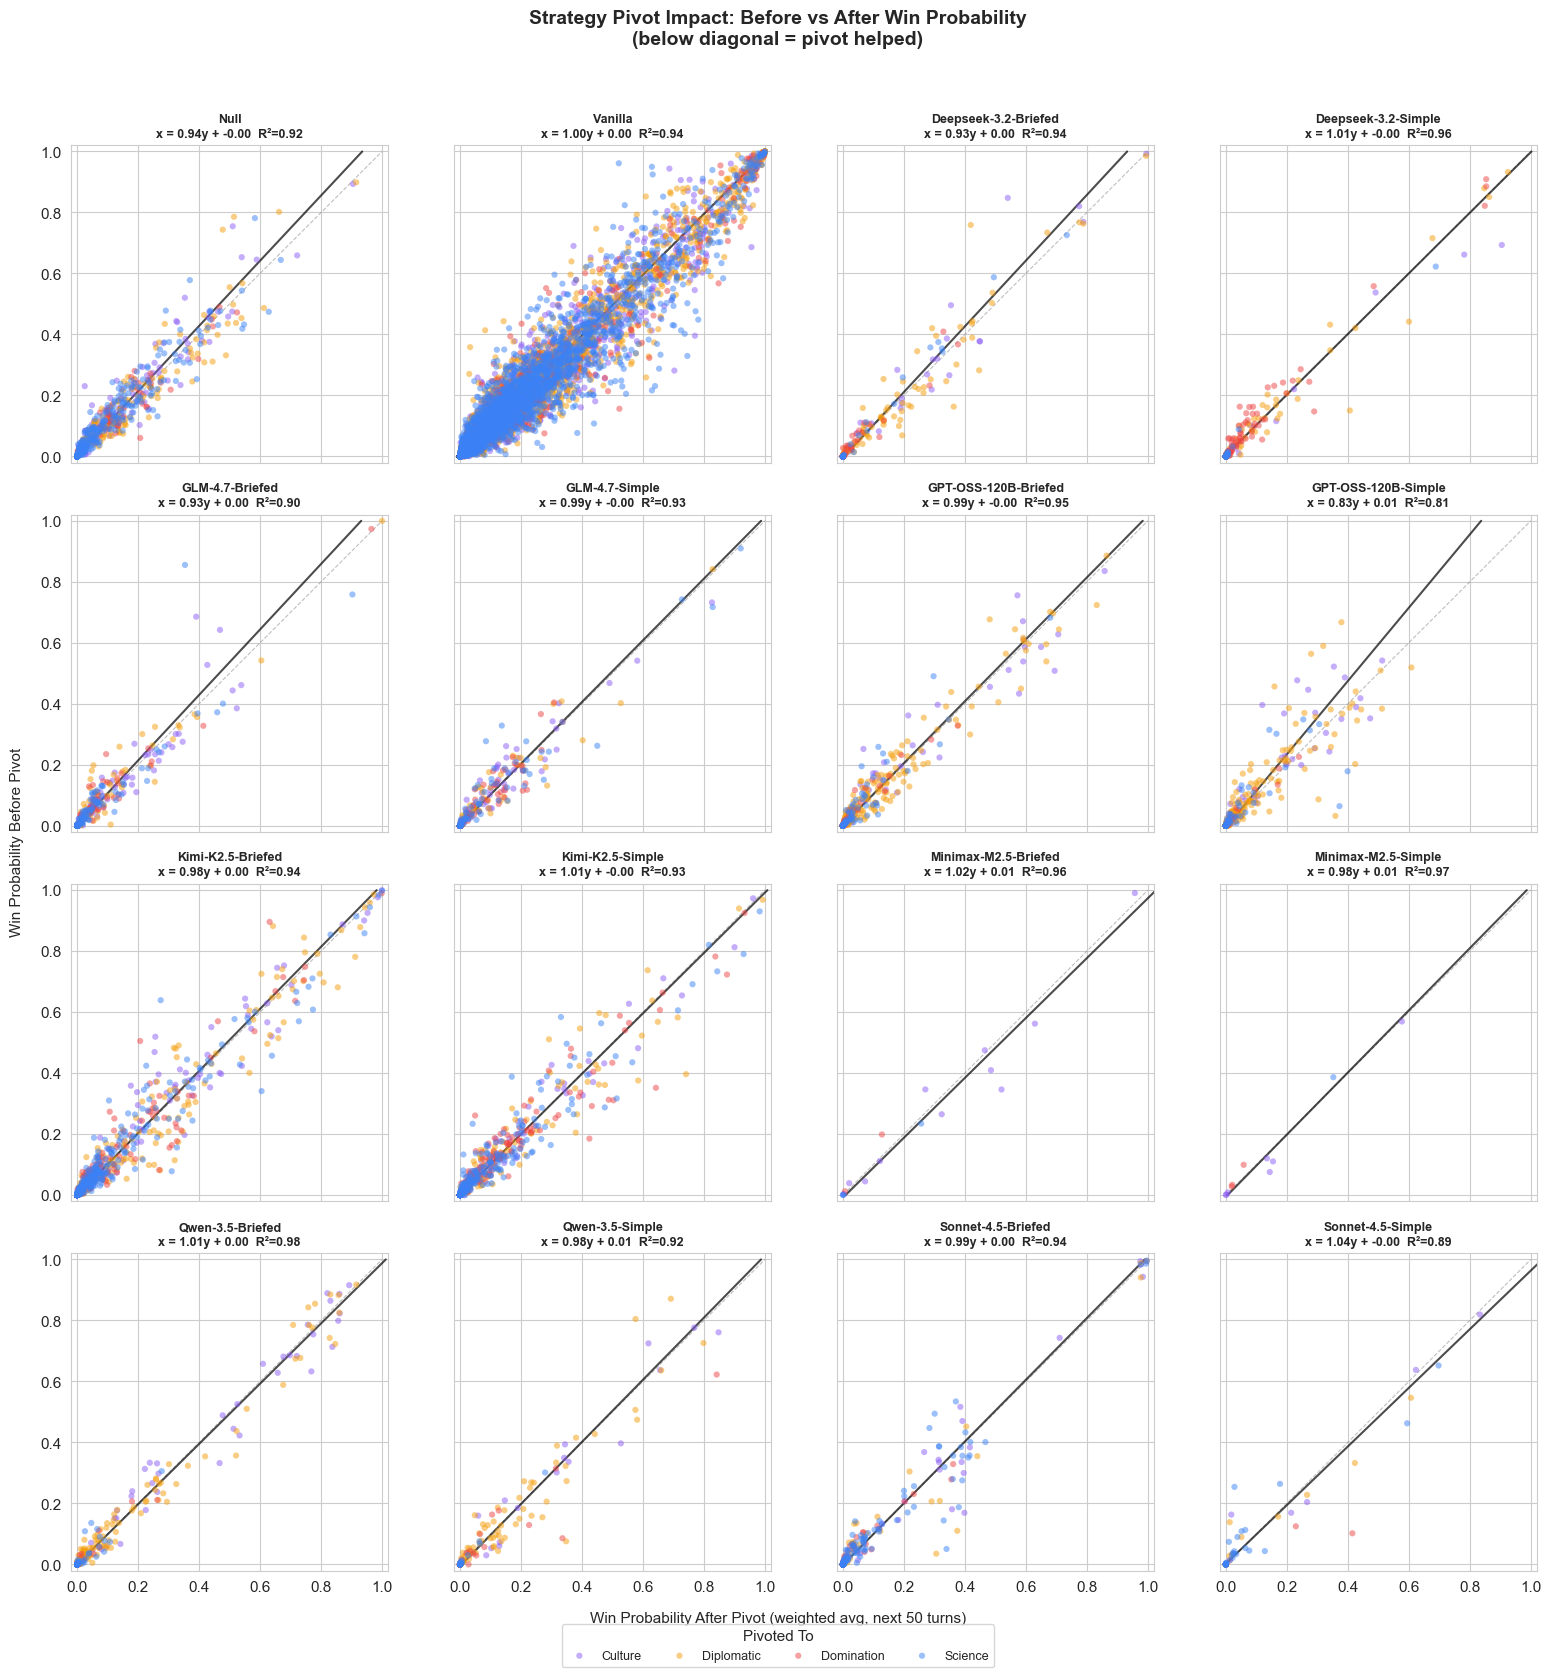

In [105]:
WINDOW = 50

pivots_scatter = pivots.copy()
pivots_scatter['after_prob'] = compute_post_pivot_win_prob(pivots, turn_df, window=WINDOW)
pivots_scatter = pivots_scatter.dropna(subset=['predicted_win_probability', 'after_prob'])

print(f'Pivots with before+after data: {len(pivots_scatter)}/{len(pivots)}')

# Faceted scatter plot
strat_types = sorted(pivots_scatter['strategy_filled'].dropna().unique())
STRATEGY_COLORS = {
    'Culture': '#8B5CF6',      # violet
    'Diplomatic': '#F59E0B',   # amber
    'Domination': '#EF4444',   # red
    'Science': '#3B82F6',      # blue
}
strat_color_map = {s: STRATEGY_COLORS.get(s, '#888888') for s in strat_types}

n_cols = 4
n_rows = int(np.ceil(len(player_order) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=True, sharey=True)
axes_flat = axes.flatten()

for idx, pt in enumerate(player_order):
    ax = axes_flat[idx]
    pt_data = pivots_scatter[pivots_scatter['player_type'] == pt]

    # Diagonal reference line
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=0.8, alpha=0.5, zorder=1)

    for s in strat_types:
        s_data = pt_data[pt_data['strategy_filled'] == s]
        if len(s_data) == 0:
            continue
        ax.scatter(
            s_data['after_prob'], s_data['predicted_win_probability'],
            color=strat_color_map[s], label=s, alpha=0.5, s=20, zorder=3, edgecolors='none'
        )

    # Linear fit across all strategies for this player type
    # Regress x (after_prob) on y (before_prob) so the line predicts after from before
    title = pt
    if len(pt_data) >= 2:
        coeffs = np.polyfit(pt_data['predicted_win_probability'], pt_data['after_prob'], 1)
        r = np.corrcoef(pt_data['predicted_win_probability'], pt_data['after_prob'])[0, 1]
        r2 = r ** 2
        fit_y = np.linspace(0, 1, 100)
        fit_x = np.polyval(coeffs, fit_y)
        ax.plot(fit_x, fit_y, color='black', linewidth=1.5, linestyle='-', alpha=0.7, zorder=2)
        title += f'\nx = {coeffs[0]:.2f}y + {coeffs[1]:.2f}  R²={r2:.2f}'

    ax.set_title(title, fontsize=9, fontweight='bold')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')

for idx in range(len(player_order), len(axes_flat)):
    axes_flat[idx].set_visible(False)

fig.supxlabel(f'Win Probability After Pivot (weighted avg, next {WINDOW} turns)', fontsize=11)
fig.supylabel('Win Probability Before Pivot', fontsize=11)

handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(strat_types),
           fontsize=9, bbox_to_anchor=(0.5, -0.02), title='Pivoted To')

fig.suptitle('Strategy Pivot Impact: Before vs After Win Probability\n(below diagonal = pivot helped)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Pivot Context Summary by Win Probability Bin

In [106]:
pivot_bin_labels = ['<0.05', '0.05-0.15', '0.15-0.30', '>0.30']
pivot_bin_edges = [-0.001, 0.05, 0.15, 0.30, 1.0]

pivot_context = pivots_scatter.copy()
pivot_context['wp_bin'] = pd.cut(
    pivot_context['predicted_win_probability'],
    bins=pivot_bin_edges,
    labels=pivot_bin_labels,
    include_lowest=True,
)
pivot_context['improved'] = (
    pivot_context['after_prob'] >= pivot_context['predicted_win_probability']
)

pivot_bin_summary = (
    pivot_context
    .groupby(['player_type', 'wp_bin'], observed=False)
    .agg(
        pivot_count=('improved', 'size'),
        improve_rate=('improved', 'mean'),
    )
    .reset_index()
)

full_index = pd.MultiIndex.from_product(
    [player_order, pivot_bin_labels],
    names=['player_type', 'wp_bin'],
)
pivot_bin_summary = (
    pivot_bin_summary
    .set_index(['player_type', 'wp_bin'])
    .reindex(full_index)
    .reset_index()
)
pivot_bin_summary['pivot_count'] = pivot_bin_summary['pivot_count'].fillna(0).astype(int)

totals = pivot_bin_summary.groupby('player_type')['pivot_count'].transform('sum')
pivot_bin_summary['share_of_model_pivots'] = np.where(
    totals > 0,
    pivot_bin_summary['pivot_count'] / totals * 100,
    0.0,
)

share_matrix = (
    pivot_bin_summary
    .pivot(index='player_type', columns='wp_bin', values='share_of_model_pivots')
    .reindex(index=player_order, columns=pivot_bin_labels)
)
improve_matrix = (
    pivot_bin_summary
    .pivot(index='player_type', columns='wp_bin', values='improve_rate')
    .reindex(index=player_order, columns=pivot_bin_labels)
)
count_matrix = (
    pivot_bin_summary
    .pivot(index='player_type', columns='wp_bin', values='pivot_count')
    .reindex(index=player_order, columns=pivot_bin_labels)
)

share_annot = np.empty(share_matrix.shape, dtype=object)
improve_annot = np.empty(improve_matrix.shape, dtype=object)
for i, pt in enumerate(player_order):
    for j, bin_label in enumerate(pivot_bin_labels):
        n_val = int(count_matrix.loc[pt, bin_label])
        if n_val == 0:
            share_annot[i, j] = ''
            improve_annot[i, j] = ''
            continue
        share_val = share_matrix.loc[pt, bin_label]
        improve_val = improve_matrix.loc[pt, bin_label]
        share_annot[i, j] = f'{share_val:.1f}%\n(n={n_val})'
        improve_annot[i, j] = f'{improve_val * 100:.1f}%\n(n={n_val})'

fig, axes = plt.subplots(
    1,
    2,
    figsize=(15, len(player_order) * 0.55 + 1.8),
    gridspec_kw={'width_ratios': [1, 1]},
)

sns.heatmap(
    share_matrix,
    annot=share_annot,
    fmt='',
    cmap='Blues',
    vmin=0,
    vmax=max(share_matrix.max().max(), 1),
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': '% of Model Pivots'},
    ax=axes[0],
)
axes[0].set_title('Pivot Context Mix by Win Probability Bin', fontweight='bold')
axes[0].set_xlabel('Pivot-Time Win Probability Bin')
axes[0].set_ylabel('')

sns.heatmap(
    improve_matrix,
    annot=improve_annot,
    fmt='',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    center=0.5,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Improve Rate'},
    ax=axes[1],
)
axes[1].set_title('Pivot Improvement Rate Within Each Bin', fontweight='bold')
axes[1].set_xlabel('Pivot-Time Win Probability Bin')
axes[1].set_ylabel('')

fig.suptitle(
    'Pivot Context Summary by Win Probability Bin\n(left = distress-heavy vs proactive pivot mix, right = improve rate within each context)',
    fontsize=14,
    fontweight='bold',
    y=1.02,
)
plt.tight_layout()
plt.show()
